# 🩺 Phát hiện viêm phổi sử dụng mạng nơ ron tích chập CNN (PyTorch)

Chuẩn đoán bằng hình ảnh là phương pháp phổ biến để phát hiện bệnh. Tuy nhiên, ở một số vùng khó quan sát, việc chuẩn đoán của bác sĩ và các thiết bị chuẩn đoán vẫn còn nhiều hạn chế.


Chúng tôi đã xây dựng một ứng dụng AI sử dụng mạng nơ-ron tích chập **Convolutional Neural Network** để hỗ trợ việc phân tích ảnh X-quang nhanh tróng và chính xác hơn


Chúng ta sẽ bắt đầu chuẩn bị dữ liệu, từng bước xây dựng mô hình, huấn huyện và chiển khai nó

# 📂 Step 1: Tải tập dữ liệu Chest X-Ray Pneumonia

Chúng ta sẽ sử dụng bộ dữ liệu **Chest X-Ray Pneumonia** từ Kaggle.  

Bộ dữ liệu này bao gồm các ảnh X-quang ngực được đánh nhãn **NORMAL** hoặc **PNEUMONIA**


In [1]:
!pip install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import kagglehub
import shutil, os

# 1. Tải về cache
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Cache path:", path)

# 2. Chỉ định nơi bạn muốn lưu
target_dir = "./data/chest_xray-pneumonia"
os.makedirs(target_dir, exist_ok=True)

# 3. Copy toàn bộ dữ liệu sang thư mục đó
shutil.copytree(path, target_dir, dirs_exist_ok=True)
print("Dataset copied to:", target_dir)


Resuming download from 319815680 bytes (2143549755 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia?dataset_version_number=2 (319815680/2463365435) bytes left.


100%|██████████| 2.29G/2.29G [34:43<00:00, 1.03MB/s] 

Extracting files...


Cache path: C:\Users\AN\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
Dataset copied to: ./data/chest_xray-pneumonia


# 🛠 Step 2: Cài đặt 1 số thư viện cần thiết

Chúng ta sẽ sử dụng 1 số thư viện thiết yếu sau:

- **os / cv2** → file handling & image preprocessing  
- **numpy** → numerical operations  
- **tqdm** → progress tracking  
- **Counter** → quick class frequency counts  
- **matplotlib / seaborn** → data visualization  
- **sklearn** → dataset splitting  

👉Những thư viện này sẽ giúp xây dựng pipeline tiền xử lý dữ liệu

In [5]:
import os  # for file/directory operations
import cv2  # computer vision library for image processing
import numpy as np  # array operations and math functions
import random  # for shuffling and sampling
from tqdm import tqdm  # to visualize long-running operations
from collections import Counter  # for counting frequency of elements
import matplotlib.pyplot as plt  # for creating graphs and charts
from sklearn.model_selection import train_test_split  # for splitting data into train/test sets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


# 📊 Step 3: Tổ chức lại tập dữ liệu

Vì tập dữ liệu **Chest X-Ray Pneumonia** từ Kaggle chứa các tập dữ liệu không đồng đều

Chúng ta sẽ tái cấu trúc tập dữ liệu thành **train / validation / test**.

- Training: 80%  
- Validation: 10%  
- Testing: 10%  

Mỗi tập có tập con là `NORMAL` và `PNEUMONIA`.  

👉 Đảm bảo một quy trình đào tạo và đánh giá rõ ràng.


In [6]:
# Paths
INPUT_DIR = "data/chest_xray-pneumonia/chest_xray/chest_xray"
OUTPUT_DIR = "data/chest_xray_split"
SPLITS = ["train", "val", "test"]

# Tập hợp tất cả ảnh theo từng thư mục gốc
images_by_class = {}

for split in SPLITS:
    split_path = os.path.join(INPUT_DIR, split)
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            images_by_class[f"{split}_{class_name}"] = [
                os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]

### In ra số lượng ảnh theo từng thư mục
for key, files in images_by_class.items():
    print(f"{key}: {len(files)} images")

# Làm phẳng các thư mục ảnh, chia ảnh thành 2 mục là "normal" và "pneumonia"
all_normal_files = []
all_pneumonia_files = []

for key, files in images_by_class.items():
    if "NORMAL" in key:
        all_normal_files.extend(files)
    elif "PNEUMONIA" in key:
        all_pneumonia_files.extend(files)

print(f"\nTotal NORMAL: {len(all_normal_files)}")
print(f"Total PNEUMONIA: {len(all_pneumonia_files)}")

# Tạo thư mục đầu ra theo cấu trúc đã xác định
for split in SPLITS:
    for label in ["NORMAL", "PNEUMONIA"]:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Chia tập dữ liệu thành các tập để huấn luyện (80% train, 10% val, 10% test)
def split_and_save(file_list, class_name):
    train_files, temp_files = train_test_split(file_list, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    split_dict = {
        "train": train_files,
        "val": val_files,
        "test": test_files
    }

    for split, files in split_dict.items():
        for filepath in tqdm(files, desc=f"Saving {split}/{class_name}"):
            img = cv2.imread(filepath)
            if img is None:
                continue
            filename = os.path.basename(filepath)
            save_path = os.path.join(OUTPUT_DIR, split, class_name, filename)
            cv2.imwrite(save_path, img)

# Process each class
split_and_save(all_normal_files, "NORMAL")
split_and_save(all_pneumonia_files, "PNEUMONIA")

print()
print("✅ Dataset saved in:", OUTPUT_DIR)


train_NORMAL: 1341 images
train_PNEUMONIA: 3875 images
val_NORMAL: 8 images
val_PNEUMONIA: 8 images
test_NORMAL: 234 images
test_PNEUMONIA: 390 images

Total NORMAL: 1583
Total PNEUMONIA: 4273


Saving test/PNEUMONIA: 100%|██████████| 428/428 [00:10<00:00, 39.85it/s]


✅ Dataset saved in: data/chest_xray_split


## Như chúng ta có thể thấy ở output trên 👆, chúng ta có tổng cộng **5856** ảnh cho tập dữ liệu này ( **1538** Normal, **4273** Pneumonia )

# 🔍 Step 4: Tải và xử lý ảnh

Mỗi bức ảnh thực hiện theo các bước sau:

1. Chuyển đổi về dạng **Đen trắng**.
2. Chuyển kích cỡ về **224 × 224 pixels** (kích thức chuẩn).  
3. Chuẩn hóa giá trị pixel trong đoạn **[0,1]**.  
4. Mở rộng kích thước để phù hợp với định dạng đầu vào PyTorch.  

Nhãn được đánh như sau:  
- `0 = NORMAL`  
- `1 = PNEUMONIA`


In [ ]:

# Define the root directory that contains the split folders
ROOT_DIR = "/data/chest_xray_split"

# Keep track of the splits you want to load
SPLITS = ["train", "val", "test"]

# Map string labels to integers for model-friendly targets
LABEL_MAP = {"NORMAL": 0, "PNEUMONIA": 1}

def load_split(split_name, target_size=(224, 224), normalize=True):
    """
    Read every image inside ROOT_DIR / split_name / class_label,
    convert it to grayscale, resize, normalize (optional),
    expand the channel dimension, and return the images with labels.
    """
    images = []
    labels = []
    bad_files = []

    # Build the split path
    split_path = os.path.join(ROOT_DIR, split_name)

    for class_name, class_index in LABEL_MAP.items():
        class_path = os.path.join(split_path, class_name)
        if not os.path.exists(class_path):
            continue

        # Iterate through files in the class folder
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Get file extension safely
            _, ext = os.path.splitext(filename)
            if ext.lower() not in {".jpg", ".jpeg", ".png"}:
                continue

            # Read the image directly in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                bad_files.append(image_path)
                continue

            # Resize to a fixed target size
            if target_size is not None:
                img = cv2.resize(img, target_size)

            # Normalize pixel values (0–1 range)
            if normalize:
                img = img.astype("float32") / 255.0

            # Expand channel axis to (H, W, 1)
            img = np.expand_dims(img, axis=-1)

            images.append(img)
            labels.append(class_index)

    if bad_files:
        print(f"[WARNING] Skipped {len(bad_files)} corrupted files in '{split_name}'")

    return images, labels


# Load every split using the reusable function
x_train, y_train = load_split("train")
x_val, y_val     = load_split("val")
x_test, y_test   = load_split("test")

# Convert lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_val,   y_val   = np.array(x_val),   np.array(y_val)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

# Display the dataset stats
print(f"Train set: {x_train.shape}, labels: {y_train.shape}")
print(f"Validation set: {x_val.shape}, labels: {y_val.shape}")
print(f"Test set: {x_test.shape}, labels: {y_test.shape}")

# Show class balance
print("Class balance in train:", Counter(y_train))
print("Class balance in val:  ", Counter(y_val))
print("Class balance in test: ", Counter(y_test))


Train set: (4684, 224, 224, 1), labels: (4684,)
Validation set: (585, 224, 224, 1), labels: (585,)
Test set: (587, 224, 224, 1), labels: (587,)
Class balance in train: Counter({np.int64(1): 3418, np.int64(0): 1266})
Class balance in val:   Counter({np.int64(1): 427, np.int64(0): 158})
Class balance in test:  Counter({np.int64(1): 428, np.int64(0): 159})


# 👀 Step 5: Trực quan hóa ảnh mẫu

Để xác định quá trình tiền xử lý có chính xác không, chúng ta phát họa 1 số ảnh ngẫu nhiên từ toàn bộ ảnh đã xử lý:  

- Ảnh X-quang (Đen trắng)  
- **Nhãn** của ảnh đó (Normal or Pneumonia)  
- Chiều của ảnh  


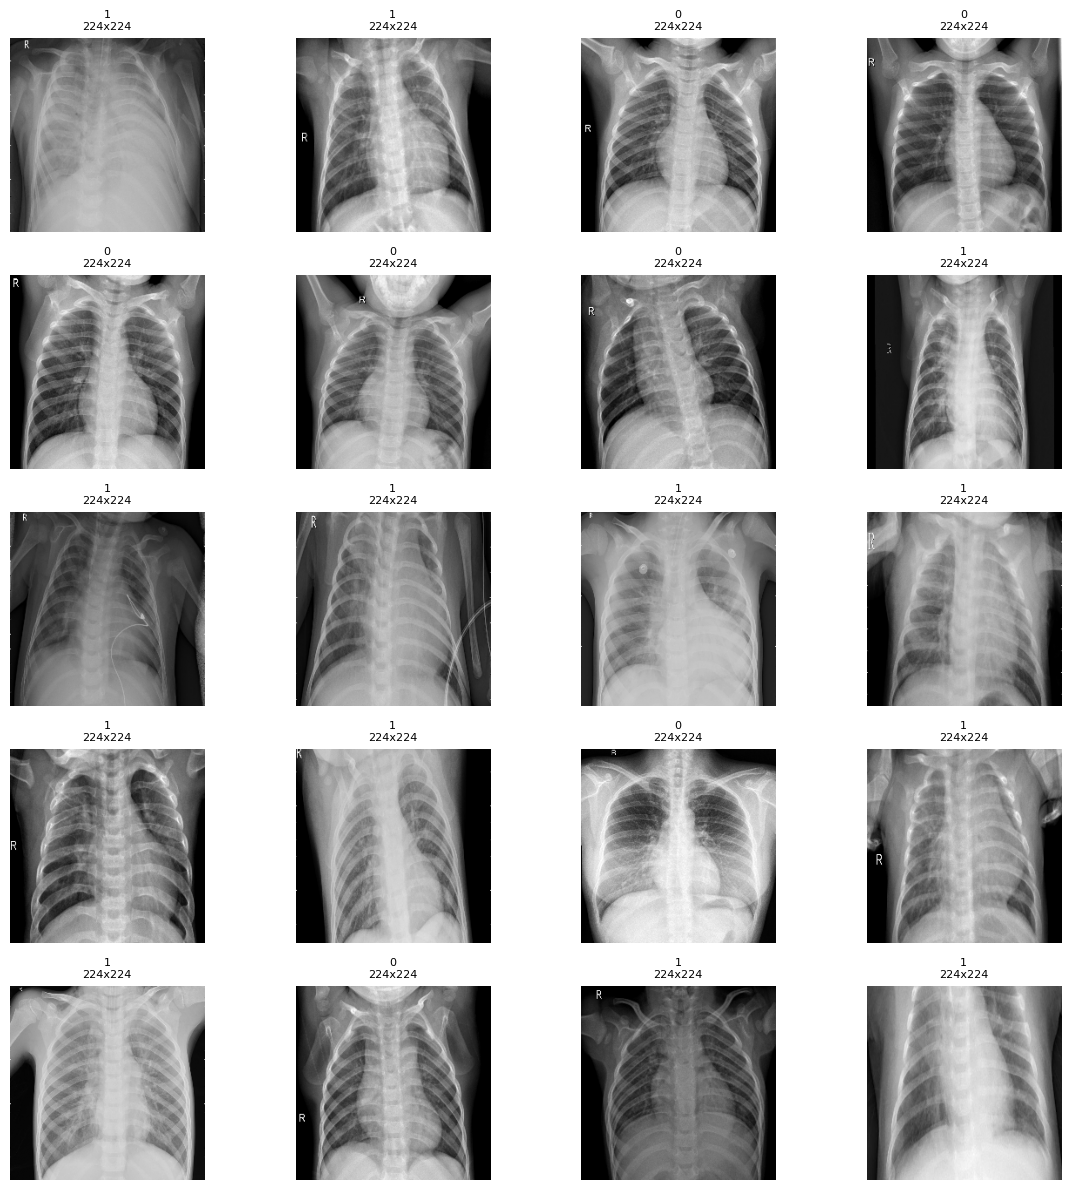

In [53]:


# Chọn 20 ảnh ngẫu nhiên
indices = random.sample(range(len(x_train)), 20)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    plt.subplot(5, 4, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    img_shape = x_train[idx].shape
    plt.title(f"{ y_train[idx]}\n{img_shape[0]}x{img_shape[1]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Nhìn vào các cạnh của tập huấn luyện, test, valid

In [54]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (4684, 224, 224, 1)
Shape of y_train: (4684,)
Shape of x_val: (585, 224, 224, 1)
Shape of y_val: (585,)
Shape of x_test: (587, 224, 224, 1)
Shape of y_test: (587,)


Những cạnh này không khớp với cạnh của Pytorch mong muốn

# 🔄 Step 6: Chuyển dữ liệu thành PyTorch Tensors

Chúng ta chuyển mảng numpy thành **PyTorch tensors**.

- Cạnh sẽ theo thứ tự từ `(N, H, W, C)` → `(N, C, H, W)`  
- Điều này phù hợp với quy ước của PyTorch: **channel-first format**  



In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Convert your existing NumPy arrays to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.LongTensor(y_train)

x_val_tensor = torch.FloatTensor(x_val).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_val_tensor = torch.LongTensor(y_val)

x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_test_tensor = torch.LongTensor(y_test)

print(f"Train: {x_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Val: {x_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test: {x_test_tensor.shape}, {y_test_tensor.shape}")

Train: torch.Size([4684, 1, 224, 224]), torch.Size([4684])
Val: torch.Size([585, 1, 224, 224]), torch.Size([585])
Test: torch.Size([587, 1, 224, 224]), torch.Size([587])


# 📦 Step 7: Tạo Dataset & DataLoader tùy chỉnh

Chúng tôi gói dữ liệu trong một **Pytorch Dataset class**, cho phép:


- Lập chỉ mục dễ dàng (`__getitem__`)
- Tải hàng loạt thông qua **DataLoader**
- Xáo trộn các mẫu

Chúng tôi cũng áp dụng **WeightedRandomSampler** để xử lý **sự mất cân bằng lớp** (số ca viêm phổi nhiều hơn số ca bình thường).

In [56]:
# Alternate to TensorDataset but from scratch :)
class ChestXRayDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    # Required by DataLoader to know when to stop iterating
    def __len__(self):
        return len(self.images)

    # Required by DataLoader to fetch individual samples during batch creation
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Create datasets
train_dataset = ChestXRayDataset(x_train_tensor, y_train_tensor)
val_dataset = ChestXRayDataset(x_val_tensor, y_val_tensor)
test_dataset = ChestXRayDataset(x_test_tensor, y_test_tensor)

In [57]:
# Calculate class weights for sampler
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {0: total_samples / class_counts[0],  # NORMAL
                 1: total_samples / class_counts[1]}   # PNEUMONIA

# Create sample weights for each training example
sample_weights = [class_weights[label.item()] for label in y_train_tensor]

# Create weighted sampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🧠 Step 8: Xây dựng mô hình và huấn luyện


##ResNet

In [58]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # dùng khi thay đổi kích thước

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # skip connection
        out = self.relu(out)
        return out

In [59]:
class PneumoniaResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super().__init__()

        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # 4 khối chính giống ResNet18
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Khởi tạo mô hình
model_ResNet = PneumoniaResNet(in_channels=1, num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model_ResNet.parameters()):,}")

Model parameters: 11,171,266


In [60]:
# Biến đổi dữ liệu (data augmentation + normalize)
train_tf = transforms.Compose([
    transforms.ToPILImage(), # Convert tensor to PIL Image
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_tf = transforms.Compose([
    transforms.ToPILImage(), # Convert tensor to PIL Image
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ResNet = model_ResNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ResNet = optim.Adam(model_ResNet.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_ResNet = ReduceLROnPlateau(optimizer_ResNet, mode='max', patience=3, factor=0.5)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Apply transforms to datasets
class TransformedChestXRayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            # Convert the PyTorch tensor back to a PIL Image before applying transforms
            image = self.transform(image)
        return image, label

train_dataset_transformed_resnet = TransformedChestXRayDataset(x_train_tensor, y_train_tensor, transform=train_tf)
val_dataset_transformed_resnet = TransformedChestXRayDataset(x_val_tensor, y_val_tensor, transform=test_tf) # Use test_tf for validation
test_dataset_transformed_resnet = TransformedChestXRayDataset(x_test_tensor, y_test_tensor, transform=test_tf)


# Update data loaders with transformed datasets, keeping the weighted sampler for training
train_loader_resnet = DataLoader(train_dataset_transformed_resnet, batch_size=32, sampler=weighted_sampler)
val_loader_resnet = DataLoader(val_dataset_transformed_resnet, batch_size=32, shuffle=False)
test_loader_resnet = DataLoader(test_dataset_transformed_resnet, batch_size=32, shuffle=False)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20):
    best_val_acc = 0
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'backend/app/model_trained/pneumonia_model_ResNet.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

# Train the ResNet model
train_model(model_ResNet, train_loader_resnet, val_loader_resnet, optimizer_ResNet, criterion, scheduler_ResNet, epochs=20)

Epoch [1/20]
Train Loss: 0.2335, Train Acc: 90.71%
Val Loss: 0.1390, Val Acc: 94.87%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.1727, Train Acc: 93.79%
Val Loss: 0.1875, Val Acc: 92.65%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.1476, Train Acc: 94.02%
Val Loss: 0.1578, Val Acc: 94.70%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1433, Train Acc: 94.66%
Val Loss: 0.1835, Val Acc: 92.65%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1260, Train Acc: 95.13%
Val Loss: 0.1058, Val Acc: 95.38%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.1094, Train Acc: 95.79%
Val Loss: 0.1094, Val Acc: 95.90%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1056, Train Acc: 96.11%
Val Loss: 0.0815, Val Acc: 97.09%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.0997, Train Acc: 96.2

##DenseNet

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        new_features = self.layer(x)
        return torch.cat([x, new_features], 1)  # kết nối dense (concat)


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)  # giảm 1/2 kích thước
        )

    def forward(self, x):
        return self.layer(x)


class PneumoniaDenseNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2, growth_rate=32, num_layers=[4, 4, 8, 8]):
        super().__init__()

        # Layer đầu tiên (stem)
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        channels = 64
        self.dense_blocks = nn.ModuleList()
        self.trans_blocks = nn.ModuleList()

        # 4 Dense Blocks như DenseNet gốc
        for i, n_layers in enumerate(num_layers):
            block = self._make_dense_block(channels, growth_rate, n_layers)
            self.dense_blocks.append(block)
            channels += n_layers * growth_rate  # mỗi layer thêm growth_rate kênh

            # Không thêm transition sau block cuối
            if i != len(num_layers) - 1:
                out_channels = channels // 2
                self.trans_blocks.append(TransitionLayer(channels, out_channels))
                channels = out_channels

        self.bn_final = nn.BatchNorm2d(channels)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels, num_classes)

    def _make_dense_block(self, in_channels, growth_rate, n_layers):
        layers = []
        for _ in range(n_layers):
            layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.init_conv(x)
        for i, block in enumerate(self.dense_blocks):
            x = block(x)
            if i < len(self.trans_blocks):
                x = self.trans_blocks[i](x)
        x = self.bn_final(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Khởi tạo model
model_DenseNet = PneumoniaDenseNet(in_channels=1, num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model_DenseNet.parameters()):,}")

Model parameters: 1,621,186


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_DenseNet = model_DenseNet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model_DenseNet.parameters(), lr=0.001, weight_decay=1e-4) # Added weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) # Reduce LR when val_acc plateaus

# Data Augmentation transforms (applied to training data only)
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert tensor to PIL Image for transforms
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), # Convert back to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize grayscale images
])

# No augmentation for validation and test data, only normalization
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [64]:
# Apply transforms to datasets
class TransformedChestXRayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            # The tensor is (C, H, W), but ToPILImage expects (H, W, C) or (H, W)
            # Since it's grayscale (1, H, W), we can remove the channel dimension for ToPILImage
            image = self.transform(image.squeeze(0))
        return image, label

train_dataset_transformed = TransformedChestXRayDataset(x_train_tensor, y_train_tensor, transform=train_transforms)
val_dataset_transformed = TransformedChestXRayDataset(x_val_tensor, y_val_tensor, transform=val_test_transforms)
test_dataset_transformed = TransformedChestXRayDataset(x_test_tensor, y_test_tensor, transform=val_test_transforms)


# Update data loaders with transformed datasets
train_loader_DenseNet = DataLoader(train_dataset_transformed, batch_size=32, sampler=weighted_sampler) # Keep the weighted sampler
val_loader_DenseNet = DataLoader(val_dataset_transformed, batch_size=32, shuffle=False)
test_loader_DenseNet = DataLoader(test_dataset_transformed, batch_size=32, shuffle=False)


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20):
    best_val_acc = 0
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'backend/app/model_trained/pneumonia_model_DenseNet.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')


# Train the DenseNet model
train_model(model_DenseNet, train_loader_DenseNet, val_loader_DenseNet, optimizer, criterion, scheduler, epochs=20)

Epoch [1/20]
Train Loss: 0.3468, Train Acc: 85.74%
Val Loss: 0.2298, Val Acc: 91.79%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.2453, Train Acc: 90.22%
Val Loss: 0.2357, Val Acc: 90.60%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.2100, Train Acc: 91.46%
Val Loss: 0.1423, Val Acc: 95.56%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1922, Train Acc: 92.34%
Val Loss: 0.3028, Val Acc: 85.13%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1700, Train Acc: 93.15%
Val Loss: 0.1886, Val Acc: 92.82%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.1724, Train Acc: 93.06%
Val Loss: 0.6865, Val Acc: 78.80%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1751, Train Acc: 92.98%
Val Loss: 0.1930, Val Acc: 90.60%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.1534, Train Acc: 94.0

##CNN Manual

In [66]:
class PneumoniaCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):  # 1 in channels: Grayscaled images, 2 classes: NORMAL and PNEUMONIA
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),    # 3x3 conv
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.Conv2d(out_c, out_c, 3, padding=1),   # 3x3 conv (more complex features)
                nn.BatchNorm2d(out_c),                   # BatchNorm
                nn.ReLU(inplace=True),                   # Relu
                nn.MaxPool2d(2)                          # MaxPol (reduce dimensions by half)
            )

        self.layer1 = conv_block(in_channels, 32)        # first conv block (1 -> 32)
        self.layer2 = conv_block(32, 64)                 # second conv block (32 -> 64)
        self.layer3 = conv_block(64, 128)                # third conv block (64 -> 128)
        self.layer4 = conv_block(128, 256)               # forth conv block (128 -> 256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # converts size to (256, 1, 1)
        self.dropout = nn.Dropout(0.4)                   # random 40% dropout
        self.fc = nn.Linear(256, num_classes)            # fully connected layer (256 -> 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# Initialize the model
model = PneumoniaCNN(num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Model parameters: 1,174,114


In [67]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'backend/app/model_trained/pneumonia_model_manual.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

# Train the model
train_model(model, train_loader, val_loader, epochs=20)

Epoch [1/20]
Train Loss: 0.2916, Train Acc: 88.24%
Val Loss: 0.6134, Val Acc: 73.16%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.2427, Train Acc: 90.12%
Val Loss: 0.2597, Val Acc: 86.32%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.2167, Train Acc: 91.70%
Val Loss: 0.3132, Val Acc: 85.47%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1885, Train Acc: 92.93%
Val Loss: 0.1730, Val Acc: 92.31%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1760, Train Acc: 93.10%
Val Loss: 0.1513, Val Acc: 95.38%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.1723, Train Acc: 93.10%
Val Loss: 2.7543, Val Acc: 49.57%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1375, Train Acc: 94.96%
Val Loss: 0.4610, Val Acc: 86.84%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.1347, Train Acc: 94.8

##VGGNet

In [69]:
class PneumoniaVGGNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(PneumoniaVGGNet, self).__init__()

        def conv_block(in_c, out_c, num_conv):
            layers = []
            layers.append(nn.Conv2d(in_c, out_c, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            for _ in range(num_conv - 1):
                layers.append(nn.Conv2d(out_c, out_c, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(out_c))
                layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2, 2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            # Block 1
            conv_block(in_channels, 64, 1),

            # Block 2
            conv_block(64, 128, 1),

            # Block 3
            conv_block(128, 256, 2),

            # Block 4
            conv_block(256, 512, 2),

            # Block 5
            conv_block(512, 512, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Khởi tạo model
model_VGGNet = PneumoniaVGGNet(in_channels=1, num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model_VGGNet.parameters()):,}")

Model parameters: 128,778,882


In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_VGGNet = model_VGGNet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model_VGGNet.parameters(), lr=0.001, weight_decay=1e-4) # Increased weight decay

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0

    # Ensure the model is on the correct device
    model.to(device)

    # Add a learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Step the scheduler
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'backend/app/model_trained/pneumonia_model_VGGNet.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

train_loader_VGGNet, val_loader_VGGNet, test_loader_VGGNet = train_loader, val_loader, test_loader
# Train the model
train_model(model_VGGNet, train_loader_VGGNet, val_loader_VGGNet, epochs=20)

Epoch [1/20]
Train Loss: 1.7963, Train Acc: 78.89%
Val Loss: 0.5629, Val Acc: 78.29%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.3166, Train Acc: 87.60%
Val Loss: 1.0605, Val Acc: 72.31%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.3052, Train Acc: 88.79%
Val Loss: 0.2460, Val Acc: 90.60%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.2977, Train Acc: 90.14%
Val Loss: 0.2411, Val Acc: 91.79%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.2561, Train Acc: 90.84%
Val Loss: 0.3476, Val Acc: 87.69%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.2239, Train Acc: 92.06%
Val Loss: 0.1918, Val Acc: 92.31%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.2257, Train Acc: 92.21%
Val Loss: 0.2047, Val Acc: 91.45%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.1953, Train Acc: 92.3

# 📈 Step 9: Kiểm tra mô hình

Tính toán các chỉ số của tường mô hình

- Accuracy  
- Precision, Recall, F1-score  
- AUC (Area Under ROC Curve)  



In [73]:
import torch.nn.functional as F

# Model evaluation
def evaluate_model(model, test_loader, model_path):
    model.eval()
    model.load_state_dict(torch.load(model_path))

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = to_device(images, device), to_device(labels, device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Pneumonia probability

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

print("Đánh giá mô hình DenseNet:")
evaluate_model(model_DenseNet, test_loader_DenseNet, 'pneumonia_model_DenseNet.pth')
print("-" * 50)
print("Đánh giá mô hình VGGNet:")
evaluate_model(model_VGGNet, test_loader_VGGNet, 'pneumonia_model_VGGNet.pth')
print("-" * 50)
print("Đánh giá mô hình Manual:")
evaluate_model(model, test_loader, 'pneumonia_model_manual.pth')
print("-" * 50)
print("Đánh giá mô hình ResNet")
evaluate_model(model_ResNet, test_loader_resnet, 'pneumonia_model_ResNet.pth')

Đánh giá mô hình DenseNet:
Test Accuracy: 0.9608
Test Precision: 0.9606
Test Recall: 0.9608
Test F1-Score: 0.9607
Test AUC: 0.9906
--------------------------------------------------
Đánh giá mô hình VGGNet:
Test Accuracy: 0.9693
Test Precision: 0.9694
Test Recall: 0.9693
Test F1-Score: 0.9690
Test AUC: 0.9906
--------------------------------------------------
Đánh giá mô hình Manual:
Test Accuracy: 0.9608
Test Precision: 0.9617
Test Recall: 0.9608
Test F1-Score: 0.9611
Test AUC: 0.9936
--------------------------------------------------
Đánh giá mô hình ResNet
Test Accuracy: 0.9676
Test Precision: 0.9675
Test Recall: 0.9676
Test F1-Score: 0.9675
Test AUC: 0.9950


# 🌀 Step 12: Confusion Matrix

We plot the **confusion matrix** to see how well the model distinguishes:

- **True Positives** (Pneumonia correctly detected)  
- **True Negatives** (Normal correctly detected)  
- **False Positives / False Negatives**  

This gives insight into misclassifications.  
Final metrics are displayed beneath the matrix.


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_simple(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=["NORMAL", "PNEUMONIA"], cmap="Blues", values_format="d"

    )
    plt.figtext(0.02, 0.02,
                f'Accuracy: {0.9574:.4f} | Precision: {0.9575:.4f} | '
                f'Recall: {0.9574:.4f} | F1-Score: {0.9575:.4f} | AUC: {0.9913:.4f}',
                ha='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    disp.ax_.set_title("Confusion Matrix - Pneumonia Detection")
    plt.show()

plot_confusion_matrix_simple(model, test_loader, device)


# 🎯 Final Summary

In this notebook, we:

✅ Built a CNN from scratch in PyTorch  
✅ Handled dataset imbalance with weighted sampling  
✅ Achieved **~96% accuracy** and **AUC 0.99**  

📌 Next steps for improvement:  
- Data augmentation (rotations, flips, contrast changes)  
- Hyperparameter tuning  
- Trying transfer learning (e.g., ResNet, DenseNet)

This project demonstrates how deep learning can assist in **medical image diagnosis**.

Made by Youssef El Demerdash